In [7]:
# !pip install -r ../exp_requirements.txt

In [8]:
# Install using an HTTP link
# !pip install git+https://github.com/DataResponsibly/Virny.git@development

# Install using an SSH link
# !pip install git+ssh://git@github.com/DataResponsibly/Virny.git@development

In [9]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import os
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

# Credit Dataset With Null Imputer

## Import dependencies

In [26]:
import os
import pandas as pd
from datetime import datetime, timezone

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from virny.utils.custom_initializers import create_config_obj, read_model_metric_dfs
from virny.user_interfaces.metrics_computation_interfaces import compute_metrics_multiple_runs_with_db_writer
from virny.preprocessing.basic_preprocessing import preprocess_dataset
from virny.preprocessing.null_imputer import NullImputer
from virny.custom_classes.metrics_visualizer import MetricsVisualizer
from virny.custom_classes.metrics_composer import MetricsComposer
from virny.datasets.data_loaders import CreditDataset
from virny.configs.constants import ReportType

from source.db_functions import read_model_metric_dfs_from_db, connect_to_mongodb

## Initialize Input Variables

Based on the library flow, we need to create 3 input objects for a user interface:

* A **config yaml** that is a file with configuration parameters for different user interfaces for metrics computation.

* A **dataset class** that is a wrapper above the user’s raw dataset that includes its descriptive attributes like a target column, numerical columns, categorical columns, etc. This class must be inherited from the BaseDataset class, which was created for user convenience.

* Finally, a **models config** that is a Python dictionary, where keys are model names and values are initialized models for analysis. This dictionary helps conduct audits of multiple models for one or multiple runs and analyze different types of models.

In [12]:
DATASET_SPLIT_SEED = 42
TEST_SET_FRACTION = 0.2

### Create a config object

In [13]:
ROOT_DIR = os.path.join(os.getcwd(), "..")
config_yaml_path = 'experiment_config.yaml'
age_range = [i for i in range(0, 31)]
config_yaml_content = \
f"""
dataset_name: Credit
bootstrap_fraction: 0.8
n_estimators: 50  # Better to input the higher number of estimators than 100; this is only for this use case example
runs_seed_lst: [100]
sensitive_attributes_dct: {{'age': {age_range}}}
"""

with open(config_yaml_path, 'w', encoding='utf-8') as f:
    f.write(config_yaml_content)

In [14]:
config = create_config_obj(config_yaml_path=config_yaml_path)

### Preprocess the dataset and create a BaseFlowDataset class

In [15]:
data_loader = CreditDataset(subsample_size=50_000)
data_loader.X_data[data_loader.X_data.columns[:5]].head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome
123767,0.112041,50,0,0.353185,4583.0
129108,0.085335,42,0,0.550393,4583.0
77722,0.010742,32,0,0.005750,3651.0
116794,0.000000,67,0,0.000000,NaN
40873,0.015154,51,0,0.254902,6833.0


In [16]:
data_loader.full_df.isna().sum()

SeriousDlqin2yrs                           0
RevolvingUtilizationOfUnsecuredLines       0
age                                        0
NumberOfTime30-59DaysPastDueNotWorse       0
DebtRatio                                  0
MonthlyIncome                           9808
NumberOfOpenCreditLinesAndLoans            0
NumberOfTimes90DaysLate                    0
NumberRealEstateLoansOrLines               0
NumberOfTime60-89DaysPastDueNotWorse       0
NumberOfDependents                      1314
dtype: int64

In [17]:
categorial_null_columns = list(set(data_loader.columns_with_nulls).intersection(data_loader.categorical_columns))
numerical_null_columns = list(set(data_loader.columns_with_nulls).intersection(data_loader.numerical_columns))

categorical_transformer = Pipeline(
    steps=[
        ("imputer", NullImputer(categorial_null_columns, how="mode")),
        ("encoder", OneHotEncoder(sparse=False)),
    ]
)
numeric_transformer = Pipeline(
    steps=[
        ("imputer", NullImputer(numerical_null_columns, how="median")),
        ("scaler", StandardScaler())
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, data_loader.categorical_columns),
        ("num", numeric_transformer, data_loader.numerical_columns),
    ]
)

In [18]:
base_flow_dataset = preprocess_dataset(data_loader, preprocessor, TEST_SET_FRACTION, DATASET_SPLIT_SEED)

### Create a models config for metrics computation

In [19]:
models_config = {
    'LogisticRegression': LogisticRegression(C=1,
                                             max_iter=50,
                                             penalty='l2',
                                             solver='newton-cg'),
    'RandomForestClassifier': RandomForestClassifier(max_depth=4,
                                                     max_features=0.6,
                                                     min_samples_leaf=1,
                                                     n_estimators=50),
    # 'XGBClassifier': XGBClassifier(learning_rate=0.1,
    #                                max_depth=5,
    #                                n_estimators=20),
}

### Define a db writer and custom fields to insert into your database

In [20]:
client, collection, db_writer_func = connect_to_mongodb()

In [21]:
import uuid

custom_table_fields_dct = {
    'session_uuid': str(uuid.uuid4()),
    'preprocessing_techniques': 'get_dummies and scaler',
}
print('Current session uuid: ', custom_table_fields_dct['session_uuid'])

Current session uuid:  29b905c1-17cd-4081-98b4-6c18c9c23c11


## Subgroup Metrics Computation

After the variables are input to a user interface, the interface creates a **generic pipeline** based on the input dataset class to hide preprocessing complexity and provide handy attributes and methods for different types of model analysis. Later this generic pipeline is used in subgroup analyzers that compute different sets of metrics. As for now, our library supports **Subgroup Variance Analyzer** and **Subgroup Statistical Bias Analyzer**, but it is easily extensible to any other analyzers. When the variance and bias analyzers complete metrics computation, their metrics are combined, returned in a matrix format, and stored in a file if defined.

In [22]:
multiple_run_metrics_dct = compute_metrics_multiple_runs_with_db_writer(base_flow_dataset, config, models_config,
                                                                        custom_table_fields_dct, db_writer_func, debug_mode=False)

Multiple runs progress:   0%|          | 0/1 [00:00<?, ?it/s]

Analyze models in one run:   0%|          | 0/2 [00:00<?, ?it/s]

##############################  [Model 1 / 2] Analyze LogisticRegression  ##############################
Model seed:  101




2023-03-21 01:34:32 abstract_overall_variance_analyzer.py INFO    : Start classifiers testing by bootstrap


Classifiers testing by bootstrap:   0%|          | 0/50 [00:00<?, ?it/s]

2023-03-21 01:34:45 abstract_overall_variance_analyzer.py INFO    : Successfully tested classifiers by bootstrap
2023-03-21 01:34:54 abstract_overall_variance_analyzer.py INFO    : Successfully computed predict proba metrics






##############################  [Model 2 / 2] Analyze RandomForestClassifier  ##############################
Model seed:  102




2023-03-21 01:35:03 abstract_overall_variance_analyzer.py INFO    : Start classifiers testing by bootstrap


Classifiers testing by bootstrap:   0%|          | 0/50 [00:00<?, ?it/s]

2023-03-21 01:35:51 abstract_overall_variance_analyzer.py INFO    : Successfully tested classifiers by bootstrap
2023-03-21 01:36:00 abstract_overall_variance_analyzer.py INFO    : Successfully computed predict proba metrics


Look at several columns in top rows of computed metrics

In [23]:
sample_model_metrics_df = multiple_run_metrics_dct[list(models_config.keys())[0]]
sample_model_metrics_df[sample_model_metrics_df.columns[:6]].head(20)

,Metric,overall,age_priv,age_dis,Model_Seed,Model_Name
0,Mean,0.933428,0.863551,0.938890,101,LogisticRegression
1,Std,0.004654,0.008588,0.004347,101,LogisticRegression
2,IQR,0.006020,0.011217,0.005614,101,LogisticRegression
3,Entropy,0.000000,0.000000,0.000000,101,LogisticRegression
4,Jitter,0.000421,0.000703,0.000399,101,LogisticRegression
5,Per_Sample_Accuracy,0.933236,0.868248,0.938316,101,LogisticRegression
6,Label_Stability,0.999400,0.998676,0.999457,101,LogisticRegression
7,TPR,0.027982,0.089109,0.017301,101,LogisticRegression
8,TNR,0.999356,0.993590,0.999770,101,LogisticRegression
9,PPV,0.760000,0.692308,0.833333,101,LogisticRegression


## Group Metrics Composition

**Metrics Composer** is responsible for this second stage of the model audit. Currently, it computes our custom group statistical bias and variance metrics, but extending it for new group metrics is very simple. We noticed that more and more group metrics have appeared during the last decade, but most of them are based on the same subgroup metrics. Hence, such a separation of subgroup and group metrics computation allows one to experiment with different combinations of subgroup metrics and avoid subgroup metrics recomputation for a new set of grouped metrics.

In [24]:
def get_models_metrics_dct(model_metric_dfs):
    # Create columns based on values in the Subgroup column
    pivoted_model_metric_dfs = model_metric_dfs.pivot(columns='Subgroup', values='Metric_Value',
                                                      index=[col for col in model_metric_dfs.columns
                                                             if col not in ('Subgroup', 'Metric_Value')]).reset_index()
    pivoted_model_metric_dfs = pivoted_model_metric_dfs.rename_axis(None, axis=1)

    # Create a dict of metrics for each model
    models_metrics_dct = dict()
    for model_name in pivoted_model_metric_dfs['Model_Name'].unique():
        models_metrics_dct[model_name] = pivoted_model_metric_dfs[pivoted_model_metric_dfs['Model_Name'] == model_name]

    return models_metrics_dct

In [27]:
model_metric_dfs = read_model_metric_dfs_from_db(collection, custom_table_fields_dct['session_uuid'])
models_metrics_dct = get_models_metrics_dct(model_metric_dfs)

In [28]:
models_metrics_dct[list(models_metrics_dct.keys())[0]].head(20)

,Metric,Model_Seed,Model_Name,Run_Number,Dataset_Name,Num_Estimators,Tag,Record_Create_Date_Time,Session_Uuid,Preprocessing_Techniques,age_dis,age_priv,overall
0,Accuracy,101,LogisticRegression,Run_1,Credit,50,OK,2023-03-20 23:36:09.519,29b905c1-17cd-4081-98b4-6c18c9c23c11,get_dummies and scaler,0.938544,0.867586,0.933400
2,Entropy,101,LogisticRegression,Run_1,Credit,50,OK,2023-03-20 23:36:09.519,29b905c1-17cd-4081-98b4-6c18c9c23c11,get_dummies and scaler,0.000000,0.000000,0.000000
4,F1,101,LogisticRegression,Run_1,Credit,50,OK,2023-03-20 23:36:09.519,29b905c1-17cd-4081-98b4-6c18c9c23c11,get_dummies and scaler,0.033898,0.157895,0.053977
6,FNR,101,LogisticRegression,Run_1,Credit,50,OK,2023-03-20 23:36:09.519,29b905c1-17cd-4081-98b4-6c18c9c23c11,get_dummies and scaler,0.982699,0.910891,0.972018
8,FPR,101,LogisticRegression,Run_1,Credit,50,OK,2023-03-20 23:36:09.519,29b905c1-17cd-4081-98b4-6c18c9c23c11,get_dummies and scaler,0.000230,0.006410,0.000644
10,IQR,101,LogisticRegression,Run_1,Credit,50,OK,2023-03-20 23:36:09.519,29b905c1-17cd-4081-98b4-6c18c9c23c11,get_dummies and scaler,0.005614,0.011217,0.006020
12,Jitter,101,LogisticRegression,Run_1,Credit,50,OK,2023-03-20 23:36:09.519,29b905c1-17cd-4081-98b4-6c18c9c23c11,get_dummies and scaler,0.000399,0.000703,0.000421
14,Label_Stability,101,LogisticRegression,Run_1,Credit,50,OK,2023-03-20 23:36:09.519,29b905c1-17cd-4081-98b4-6c18c9c23c11,get_dummies and scaler,0.999457,0.998676,0.999400
16,Mean,101,LogisticRegression,Run_1,Credit,50,OK,2023-03-20 23:36:09.519,29b905c1-17cd-4081-98b4-6c18c9c23c11,get_dummies and scaler,0.938890,0.863551,0.933428
18,PPV,101,LogisticRegression,Run_1,Credit,50,OK,2023-03-20 23:36:09.519,29b905c1-17cd-4081-98b4-6c18c9c23c11,get_dummies and scaler,0.833333,0.692308,0.760000


In [29]:
metrics_composer = MetricsComposer(models_metrics_dct, config.sensitive_attributes_dct)

Compute composed metrics

In [30]:
models_composed_metrics_df = metrics_composer.compose_metrics()

## Metrics Visualization and Reporting

**Metrics Visualizer** provides metrics visualization and reporting functionality. It unifies different preprocessing methods for result metrics and creates various data formats required for visualizations. Hence, users can simply call methods of the Metrics Visualizer class and get custom plots for diverse metrics analysis. Additionally, these plots could be collected in an HTML report with comments for user convenience and future reference.

In [31]:
visualizer = MetricsVisualizer(models_metrics_dct, models_composed_metrics_df, config.dataset_name,
                               model_names=list(models_config.keys()),
                               sensitive_attributes_dct=config.sensitive_attributes_dct)

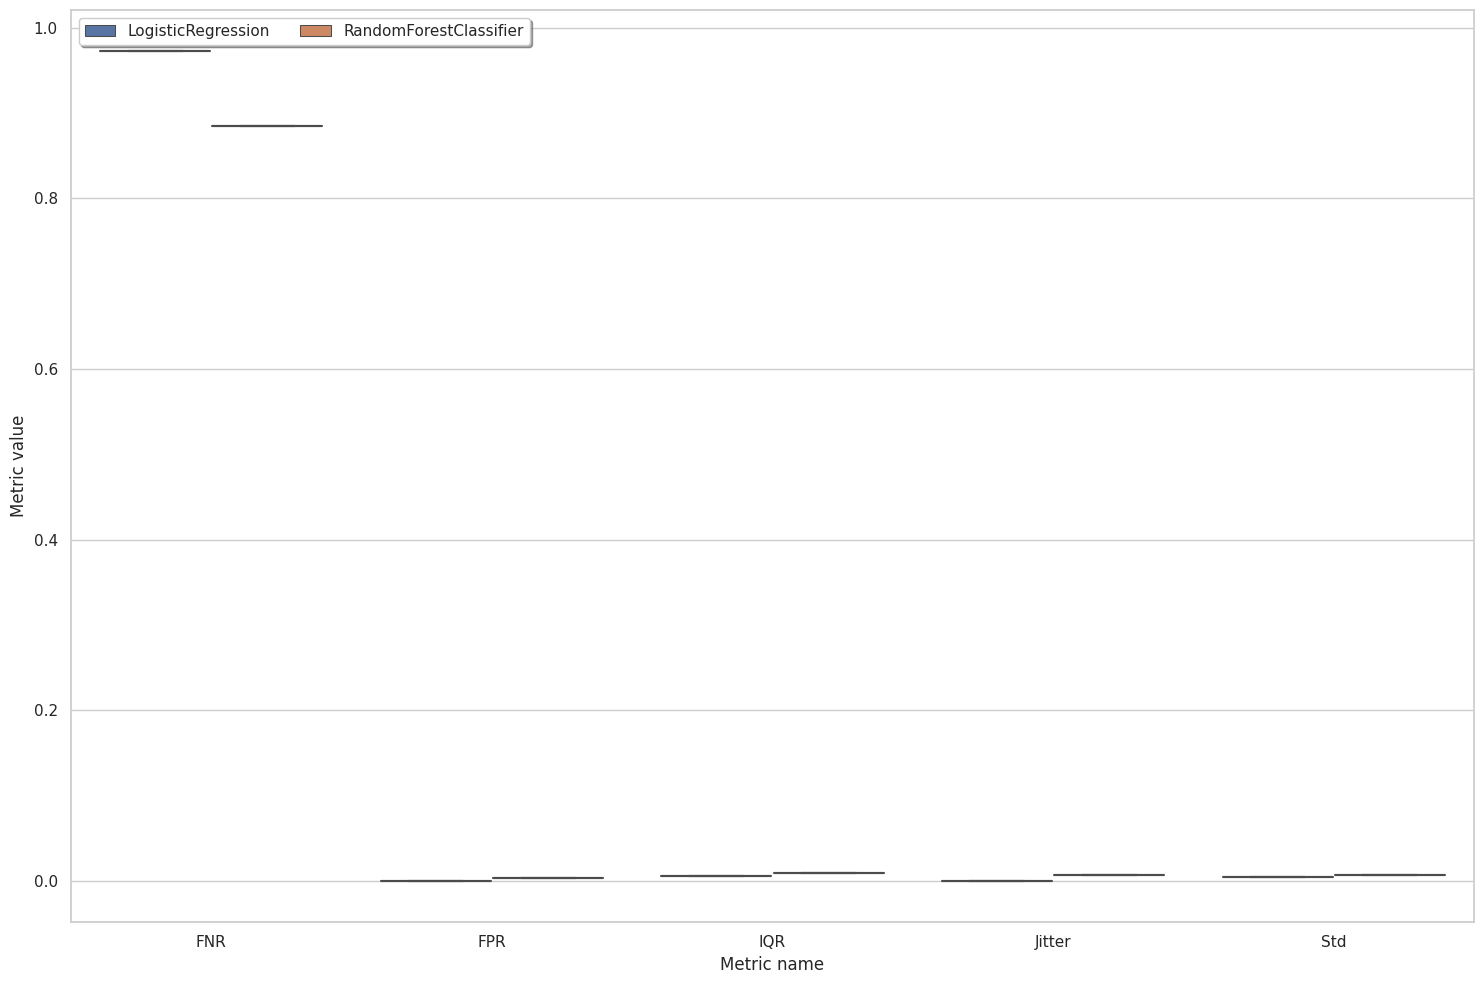

In [32]:
visualizer.create_boxes_and_whiskers_for_models_multiple_runs(metrics_lst=['Std', 'IQR', 'Jitter', 'FNR','FPR'])

In [33]:
visualizer.create_overall_metrics_bar_char(
    metrics_names=['TPR', 'PPV', 'Accuracy', 'F1', 'Selection-Rate', 'Positive-Rate'],
    metrics_title="Bias Metrics"
)

alt.Chart(...)

In [34]:
visualizer.create_overall_metrics_bar_char(
    metrics_names=['Label_Stability'],
    reversed_metrics_names=['Std', 'IQR', 'Jitter'],
    metrics_title="Variance Metrics"
)

alt.Chart(...)

Below is an example of an interactive plot. It requires that you run the below cell in Jupyter in the browser or EDAs, which support JavaScript displaying.

You can use this plot to compare any pair of bias and variance metrics for all models.

In [35]:
visualizer.create_bias_variance_interactive_bar_chart()

alt.HConcatChart(...)

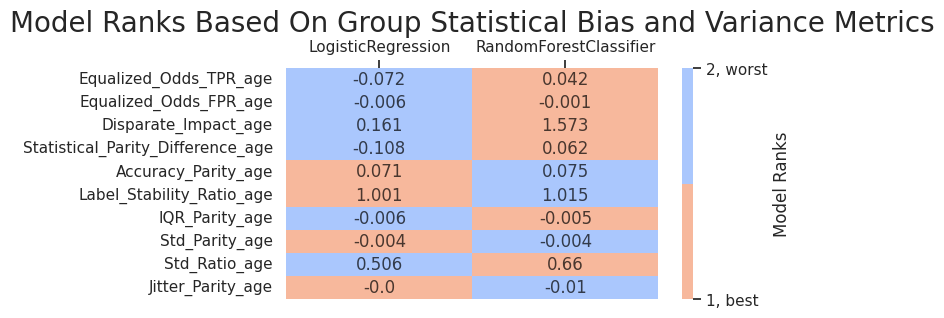

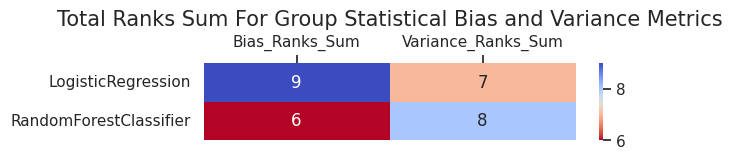

In [36]:
visualizer.create_model_rank_heatmaps(
    metrics_lst=[
        # Group statistical bias metrics
        'Equalized_Odds_TPR',
        'Equalized_Odds_FPR',
        'Disparate_Impact',
        'Statistical_Parity_Difference',
        'Accuracy_Parity',
        # Group variance metrics
        'Label_Stability_Ratio',
        'IQR_Parity',
        'Std_Parity',
        'Std_Ratio',
        'Jitter_Parity',
    ],
    groups_lst=config.sensitive_attributes_dct.keys(),
)

Create an analysis report. It includes correspondent visualizations and details about your result metrics.

In [ ]:
visualizer.create_html_report(report_type=ReportType.MULTIPLE_RUNS_MULTIPLE_MODELS,
                              report_save_path=os.path.join(ROOT_DIR, "results", "reports"))